# This notebook must be run with the Vizgen_2 conda environment within the Vizgen.sif singularity container

The code to analyze the permutations is adapted from: https://github.com/ZhuangLab/whole_mouse_brain_MERFISH_atlas_scripts_2023/blob/main/scripts/cell_cell_contacts/get_significant_contacts_30um.ipynb

In [1]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import os
import string
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
from tqdm import tqdm
import Mapping
import math
import matplotlib.pyplot as plt
import multiprocessing as mp
from functools import partial
import gseapy as gp
import networkx as nx

import skimage
import cv2
from skimage.morphology import disk, opening, closing
from scipy.ndimage import binary_fill_holes, label, distance_transform_edt
from skimage.segmentation import find_boundaries, watershed
from skimage.feature import peak_local_max
from skimage.measure import regionprops
from skimage.segmentation import watershed
import scipy.stats
import statsmodels.stats.multitest

from sklearn.mixture import GaussianMixture
from node2vec import Node2Vec
import networkx as nx
from matplotlib.lines import Line2D

/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Clustering Analysis

This section was directly adapted from the DypFISH repo: https://github.com/cbib/dypfish

In [2]:
def find_filtered_transcripts(experiment_path):
    region_types = ['region_0', 'region_1']
    for region in region_types:
        file_path = f'{experiment_path}baysor/detected_transcripts.csv'
        if os.path.exists(file_path):
            return pd.read_csv(file_path,index_col=0)
    return None

def find_filtered_transcripts(experiment_path):
    region_types = ['region_0', 'region_1']
    for region in region_types:
        file_path = f'{experiment_path}baysor/detected_transcripts.csv'
        if os.path.exists(file_path):
            return pd.read_csv(file_path,index_col=0)
    return None

def sem(a: np.array, factor=3) -> float:
    """
    sem in presence of extreme outliers (very skewed distribution), factor = 0 gives standard behaviour
    """
    if factor > 0:
        limit = factor * np.std(a)
        a = a[(a < np.mean(a) + limit) & (a > np.mean(a) - limit)]
    return scipy.stats.sem(a, ddof=0)

def mean_confidence_interval(a: np.array, cutoff=.95):
    ''' cutoff is the significance level as a decimal between 0 and 1'''
    a = np.sort(a)
    factor = scipy.stats.norm.ppf((1 + cutoff) / 2)
    factor *= math.sqrt(len(a))  # avoid doing computation twice

    lix = int(0.5 * (len(a) - factor)) + 1
    uix = int(0.5 * (1 + len(a) + factor)) + 1
    if lix < 0:
        lix = 0
    if uix > len(a)-1:
        uix = len(a)-1
    assert (lix > 0), "index " + str(lix) + " is out of bound for array of size 0"
    assert (uix <= len(a)-1), "index " + str(uix) + " is out of bound for array of size " + str(len(a))

    return a[lix], a[uix]

def compute_degree_of_clustering(genes_list, batches_list, morphology,path_of_data,compartment='_branches'):
    individual_cells = []
    for batch in batches_list:
        for morph in morphology:
            load_path = f"{path_of_data}{batch}/morph_{morph}/degree_of_clustering{compartment}.npy"
            if os.path.exists(load_path):
                individual_cells.append(np.load(load_path))
        
    cluster = np.concatenate(individual_cells,axis=1)
    cluster_list = [row[row != 0.0001] for row in cluster]
    
    gene2_degree_of_clustering = {}
    gene2mean_degree_of_clustering = {}
    gene2error_degree_of_clustering = {}
    gene2confidence_interval = {}
    degrees_of_clustering = []

    for gene, degree_of_clustering in zip(genes, cluster_list):
        degree_of_clustering = np.log(degree_of_clustering)
        gene2_degree_of_clustering[gene] = degree_of_clustering
        gene2mean_degree_of_clustering[gene] = np.mean(degree_of_clustering)
    # Standard error and CI computation
        gene2error_degree_of_clustering[gene] = sem(degree_of_clustering, factor=0)
        if len(degree_of_clustering) > 1:
            lower, higher = mean_confidence_interval(degree_of_clustering)
        else:
            lower=0
            higher=0
        gene2confidence_interval[gene] = [lower, higher]
    return gene2_degree_of_clustering, gene2mean_degree_of_clustering, gene2error_degree_of_clustering, gene2confidence_interval

def get_filtered_genes(median_values, error_values):
    """
    Filters genes with non-zero errors from the median values dictionary.

    Args:
    - median_values: Dictionary of median values {gene: value, ...}.
    - error_values: Dictionary of error values {gene: error, ...}.

    Returns:
    - List of tuples [(gene, median_value), ...] for genes with non-zero errors.
    """
    # Filter genes with non-zero errors
    filtered_genes = [
        (gene, median) for gene, median in median_values.items()
        if error_values.get(gene, 0) != 0
    ]
    return filtered_genes

def find_genes_with_largest_deviation_and_significance(
    filtered_young_genes, 
    filtered_old_genes, 
    median_young, 
    median_old, 
    d_of_c_young, 
    d_of_c_old, 
    significance_threshold=0.05
):
    """
    Identify genes in both filtered young and old genes, compute their deviation, 
    and filter by significant p-values.

    Args:
    - filtered_young_genes: List of tuples [(gene, median_value_y), ...] for young samples.
    - filtered_old_genes: List of tuples [(gene, median_value_o), ...] for old samples.
    - median_young: Dictionary of medians for young samples {gene: value, ...}.
    - median_old: Dictionary of medians for old samples {gene: value, ...}.
    - d_of_c_young: Dictionary of d_of_c arrays for young samples {gene: array, ...}.
    - d_of_c_old: Dictionary of d_of_c arrays for old samples {gene: array, ...}.
    - significance_threshold: Threshold for p-value significance.

    Returns:
    - List of tuples [(gene, deviation, p-value), ...] filtered by significant p-values.
    """
    from scipy.stats import ranksums
    import numpy as np

    # Extract the gene names from the filtered lists
    young_genes_set = {gene for gene, _ in filtered_young_genes}
    old_genes_set = {gene for gene, _ in filtered_old_genes}
    
    # Find common genes in both filtered lists
    common_genes = young_genes_set.intersection(old_genes_set)
    
    # Compute deviations and p-values for the common genes
    significant_genes = []
    for gene in common_genes:
        young_value = median_young[gene]
        old_value = median_old[gene]
        
        # Compute deviation
        deviation = abs(young_value - old_value)
        if np.isnan(deviation):
            deviation = 0
        
        # Perform t-test
        young_values = d_of_c_young.get(gene, [])
        old_values = d_of_c_old.get(gene, [])
        stat, p_value = ranksums(young_values, old_values)
        
        # Check significance
        if p_value < significance_threshold:
            significant_genes.append((gene, deviation, p_value))
    
    # Sort by largest deviation
    sorted_genes = sorted(significant_genes, key=lambda x: x[1], reverse=True)
    
    return sorted_genes

def plot_hued_median_bar(young_dict, old_dict,ylim=None,output_pdf=None):
    # Extract genes, medians, and errors for young and old samples
    all_genes = list(young_dict[1].keys())  # Assuming the same genes are in both dictionaries
    young_medians = list(young_dict[1].values())
    young_err = list(young_dict[2].values())
    old_medians = list(old_dict[1].values())
    old_err = list(old_dict[2].values())
    
    bar_width = 0.35  # Width of individual bars
    ind = np.arange(len(all_genes))  # X locations for the groups
    fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figure size as needed
    
    # Plot bars for young and old
    ax.bar(ind - bar_width/2, young_medians, bar_width, yerr=young_err, label="Young", color='skyblue')
    ax.bar(ind + bar_width/2, old_medians, bar_width, yerr=old_err, label="Old", color='salmon')
    
    # Customize the axes
    ax.set_xlabel("Genes", fontsize=15)
    ax.set_ylabel("Mean Values", fontsize=15)
    ax.set_title("Comparison of Gene Expression Between Young and Old Samples", fontsize=18)
    ax.set_xticks(ind)
    ax.set_xticklabels(all_genes, fontsize=10)
    ax.yaxis.grid(which="major", color='black', linestyle='-', linewidth=0.25)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=10, rotation=45)  # Optional: rotate gene labels for clarity
    
    # Style the ticks and spines
    ax.tick_params(right=False, top=False, bottom=True, direction='out', length=8, width=3, colors='black')
    ax.spines['left'].set_linewidth(3)
    if ylim:
        ax.set_ylim(ylim[0],ylim[1])
        
    if output_pdf:
        plt.savefig(output_pdf,format='pdf')
    
    # Add a legend
    ax.legend(fontsize=12)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

In [3]:
output_path = 'cluster_output/'
morphologies = ['0','1','2','3','4']
batches =['3-mo-male-1',
          '3-mo-male-2',
          '3-mo-male-3-rev2',
          '3-mo-female-1-rev2',
          '3-mo-female-2',
          '3-mo-female-3',
          '24-mo-male-1',
          '24-mo-male-2',
          '24-mo-male-4-rev2',
          '24-mo-female-1',
          '24-mo-female-3',
          '24-mo-female-5']
base_data_path = '/hpc/projects/group.quake/doug/Shapes_Spatial/'

In [4]:
transcripts = find_filtered_transcripts(base_data_path+batches[-1]+'/')
genes = np.unique(transcripts.gene.unique().tolist())

In [5]:
batches_3m = [
          '3-mo-male-1',
          '3-mo-male-2',
          '3-mo-male-3-rev2',
          '3-mo-female-1-rev2',
          '3-mo-female-2',
          '3-mo-female-3'
]

batches_24m = [
          '24-mo-male-1',
          '24-mo-male-2',
          '24-mo-male-4-rev2',
          '24-mo-female-1',
          '24-mo-female-3',
          '24-mo-female-5'
]

d_of_c_b_y, median_d_of_c_b_y, err_b_y, confidence_interval_b_y = compute_degree_of_clustering(genes, batches_3m, ['3','4'],output_path,compartment='_branches')
d_of_c_b_o, median_d_of_c_b_o, err_b_o, confidence_interval_b_o = compute_degree_of_clustering(genes, batches_24m, ['3','4'],output_path,compartment='_branches')

d_of_c_s_y, median_d_of_c_s_y, err_s_y, confidence_interval_s_y = compute_degree_of_clustering(genes, batches_3m, ['3','4'],output_path,compartment='_soma')
d_of_c_s_o, median_d_of_c_s_o, err_s_o, confidence_interval_s_o = compute_degree_of_clustering(genes, batches_24m, ['3','4'],output_path,compartment='_soma')

filtered_y_s = get_filtered_genes(median_d_of_c_s_y, err_s_y)
filtered_o_s = get_filtered_genes(median_d_of_c_s_o, err_s_o)

filtered_y_b = get_filtered_genes(median_d_of_c_b_y, err_b_y)
filtered_o_b = get_filtered_genes(median_d_of_c_b_o, err_b_o)

largest_significant_s_genes = find_genes_with_largest_deviation_and_significance(
    filtered_y_s, 
    filtered_o_s, 
    median_d_of_c_s_y, 
    median_d_of_c_s_o, 
    d_of_c_s_y, 
    d_of_c_s_o, 
    significance_threshold=0.05
)

largest_significant_b_genes = find_genes_with_largest_deviation_and_significance(
    filtered_y_b, 
    filtered_o_b, 
    median_d_of_c_b_y, 
    median_d_of_c_b_o, 
    d_of_c_b_y, 
    d_of_c_b_o, 
    significance_threshold=0.05
)

print("Significant Soma Genes with Largest Deviations:")
soma_genes = []
for gene, deviation, p_value in largest_significant_s_genes:
    print(f"Gene: {gene}, Deviation: {deviation:.4f}, P-Value: {p_value:.4f}")
    soma_genes.append(gene)
    
print("Significant Branch Genes with Largest Deviations:")
branch_genes = []
for gene, deviation, p_value in largest_significant_b_genes:
    print(f"Gene: {gene}, Deviation: {deviation:.4f}, P-Value: {p_value:.4f}")
    branch_genes.append(gene)

/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Significant Soma Genes with Largest Deviations:
Gene: Baiap3, Deviation: 0.3331, P-Value: 0.0442
Gene: Foxj1, Deviation: 0.3054, P-Value: 0.0484
Gene: Bmpr2, Deviation: 0.2671, P-Value: 0.0358
Gene: P2ry12, Deviation: 0.2065, P-Value: 0.0008
Gene: Inpp5d, Deviation: 0.1908, P-Value: 0.0131
Gene: Gfap, Deviation: 0.1645, P-Value: 0.0065
Gene: Itgam, Deviation: 0.1455, P-Value: 0.0473
Gene: Slc1a2, Deviation: 0.1080, P-Value: 0.0191
Significant Branch Genes with Largest Deviations:
Gene: Apod, Deviation: 0.6629, P-Value: 0.0019
Gene: Cx3cr1, Deviation: 0.3521, P-Value: 0.0105
Gene: Apoe, Deviation: 0.0754, P-Value: 0.0009
Gene: Gnas, Deviation: 0.0627, P-Value: 0.0010
Gene: Aldoc, Deviation: 0.0443, P-Value: 0.0104
Gene: Slc1a2, Deviation: 0.0410, P-Value: 0.0091


/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/scipy/stats/_stats_py.py:9154: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


In [6]:
branch_young_dicts = [d_of_c_b_y,median_d_of_c_b_y,err_b_y,confidence_interval_b_y]
branch_old_dicts = [d_of_c_b_o,median_d_of_c_b_o,err_b_o,confidence_interval_b_o]
soma_young_dicts = [d_of_c_s_y,median_d_of_c_s_y,err_s_y,confidence_interval_s_y]
soma_old_dicts = [d_of_c_s_o,median_d_of_c_s_o,err_s_o,confidence_interval_s_o]

branch_young_dicts = [{key: d[key] for key in branch_genes} for d in branch_young_dicts]
branch_old_dicts = [{key: d[key] for key in branch_genes} for d in branch_old_dicts]
soma_young_dicts = [{key: d[key] for key in soma_genes} for d in soma_young_dicts]
soma_old_dicts = [{key: d[key] for key in soma_genes} for d in soma_old_dicts]

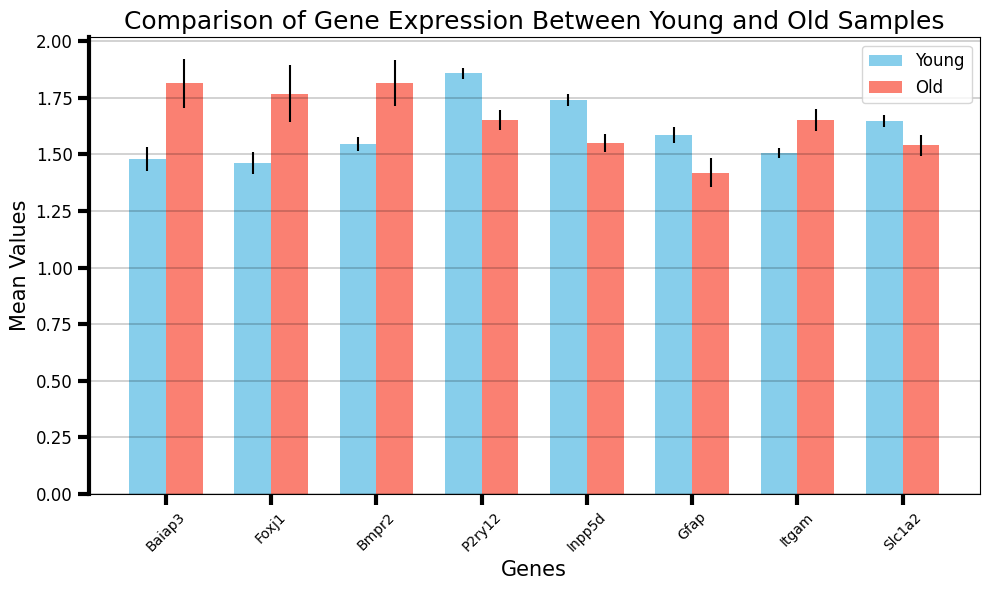

In [7]:
plot_hued_median_bar(soma_young_dicts,soma_old_dicts,output_pdf='Figures/Figure_coloc/soma_cluster.pdf')

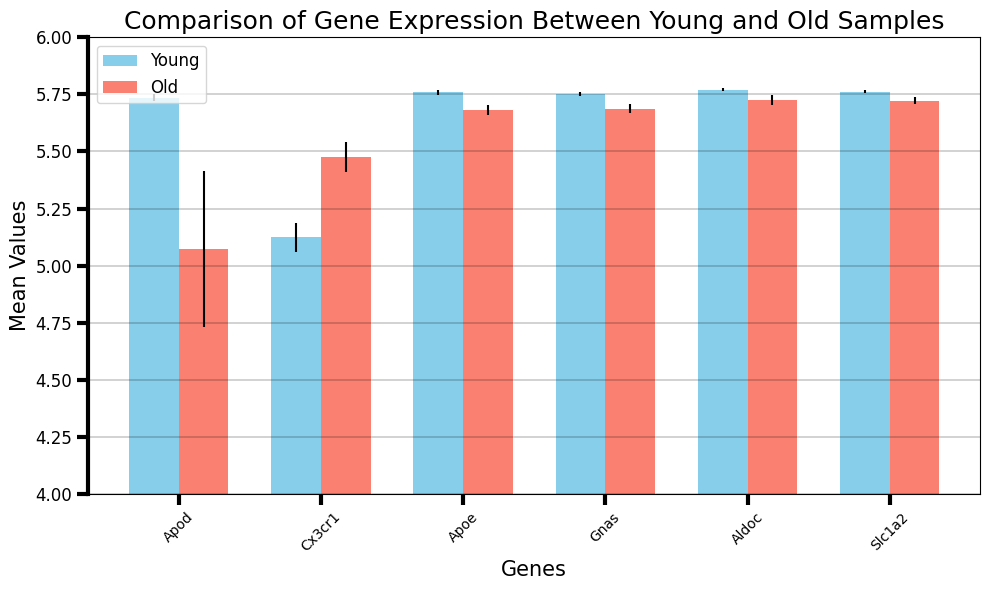

In [8]:
plot_hued_median_bar(branch_young_dicts,branch_old_dicts,ylim=[4,6],output_pdf='Figures/Figure_coloc/branch_cluster.pdf')

# Colocalization Networks

In [9]:
def count_zero_pairs(contact_mtx):
    n_0 = 0
    for i in range(contact_mtx.shape[0]):
        for j in range(i, contact_mtx.shape[0]):
            if contact_mtx[i, j] == 0:
                n_0 += 1
    return n_0

def adjust_p_value_matrix_by_BH(p_val_mtx):
    '''Adjust the p-values in a matrix by the Benjamini/Hochberg method.
    The matrix should be symmetric.
    '''
    p_val_sequential = []
    N = p_val_mtx.shape[0]
    
    for i in range(N):
        for j in range(i, N):
            p_val_sequential.append(p_val_mtx[i, j])

    p_val_sequential_bh = statsmodels.stats.multitest.multipletests(p_val_sequential, method='fdr_bh')[1]
    
    adjusted_p_val_mtx = np.zeros((N, N))
    
    counter = 0
    for i in range(N):
        for j in range(i, N):
            adjusted_p_val_mtx[i, j] = p_val_sequential_bh[counter]
            adjusted_p_val_mtx[j, i] = p_val_sequential_bh[counter]
            counter += 1
            
    return adjusted_p_val_mtx

def get_data_frame_from_metrices(cell_types, mtx_dict):
    N = len(cell_types)
    
    serials_dict = {'cell_type1':[], 'cell_type2':[]}
    for k in mtx_dict.keys():
        serials_dict[k] = []
        
    for i in range(N):
        for j in range(i, N):
            serials_dict['cell_type1'].append(cell_types[i])
            serials_dict['cell_type2'].append(cell_types[j])
            for k in mtx_dict.keys():
                serials_dict[k].append(mtx_dict[k][i, j])
                
    return pd.DataFrame(serials_dict)
    

def sort_cell_type_contact_p_values(p_val_mtx, cell_types):
    '''Return a list of (cell_type1, cell_type2, p_value) sorted by p_values.'''
    p_val_list = []
    N = p_val_mtx.shape[0]
    for i in range(N):
        for j in range(i, N):
            p_val_list.append((cell_types[i], cell_types[j], p_val_mtx[i, j]))
    return sorted(p_val_list, key=lambda x:x[2])

import scipy.cluster
#from scattermap import scattermap

def get_optimal_order_of_mtx(X):
    Z = scipy.cluster.hierarchy.ward(X)
    return scipy.cluster.hierarchy.leaves_list(
        scipy.cluster.hierarchy.optimal_leaf_ordering(Z, X))

def get_ordered_tick_labels(tick_labels):
    tick_labels_with_class = [s.split(' ')[-1] + ' ' + s for s in tick_labels]
    return np.argsort(tick_labels_with_class)

def filter_pval_mtx(pval_mtx, tick_labels, allowed_pairs):
    pval_mtx_filtered = pval_mtx.copy()
    
    for i in range(pval_mtx.shape[0]):
        ct1 = tick_labels[i]
        for j in range(pval_mtx.shape[1]):
            ct2 = tick_labels[j]
            
            if ((ct1, ct2) in allowed_pairs) or ((ct2, ct1) in allowed_pairs):
                continue
            else:
                pval_mtx_filtered[i, j] = 1
            
    return pval_mtx_filtered

def make_dotplot(pval_mtx, fold_change_mtx, tick_labels, title='', allowed_pairs=None):

    #optimal_order = get_optimal_order_of_mtx(pval_mtx)
    optimal_order = get_ordered_tick_labels(tick_labels)
    
    pval_mtx = pval_mtx[optimal_order][:, optimal_order]
    fold_change_mtx = fold_change_mtx[optimal_order][:, optimal_order]
    tick_labels = tick_labels[optimal_order]
    
    
def find_filtered_transcripts(experiment_path):
    region_types = ['region_0', 'region_1']
    for region in region_types:
        file_path = f'{experiment_path}baysor/detected_transcripts.csv'
        if os.path.exists(file_path):
            return pd.read_csv(file_path,index_col=0)
    return None

def permutation_analysis(base_path, batch_list, morphology_list, output_p,compartment='soma'):
    full_df = []
    # so I want to iterate through each geometry class
    for morph in morphology_list:
        # then through every batch
        for batch in batch_list:
            # load the gene names
            transcripts = find_filtered_transcripts(base_path+batch+'/')
            genes = np.unique(transcripts.gene.unique().tolist())
    
            gene_coloc_counts = np.load(f'{output_p}{batch}/morph_{morph}/{compartment}_no_permutation.npy')

            local_null_means = np.load(f'{output_p}{batch}/morph_{morph}/{compartment}_full_permutation_mean.npy')
            local_null_stds = np.load(f'{output_p}{batch}/morph_{morph}/{compartment}_full_permutation_std.npy')

            # Require all stds to be larger or equal to the minimal observable std value
            local_null_stds = np.maximum(local_null_stds, np.sqrt(1 / 1000))
    
            local_z_scores = (gene_coloc_counts - local_null_means) / local_null_stds
            local_p_values = scipy.stats.norm.sf(local_z_scores)
            adjusted_local_p_values = adjust_p_value_matrix_by_BH(local_p_values)
    
            fold_changes = gene_coloc_counts / (local_null_means + 1e-4)
        
            # Gather all results into a data frame
            contact_result_df = get_data_frame_from_metrices(genes, 
                                             {'pval-adjusted': adjusted_local_p_values,
                                              'pval': local_p_values,
                                              'z_score': local_z_scores,
                                              'contact_count': gene_coloc_counts,
                                              'permutation_mean': local_null_means,
                                              'permutation_std': local_null_stds,
                                            }).sort_values('z_score', ascending=False)

            
            contact_result_df.to_csv(f'{output_p}{batch}/morph_{morph}/{compartment}_close_contacts.csv')
    
            full_df.append(contact_result_df)
        
    return full_df

def calc_contacts(base_path, batches, morphologies,compartment='soma',contact_thresh = None):
    # need to record this across all of the batches
    real_arrays = []
    mean_arrays = []
    std_arrays = []
    
    # iterate over each morphology and each batch
    for morph in morphologies:
        for batch in batches:
            # Load the gene names
            transcripts = find_filtered_transcripts(base_data_path + batch + '/')
            genes = np.unique(transcripts.gene.unique().tolist())
    
            gene_coloc_counts = np.load(f'{base_path}{batch}/morph_{morph}/{compartment}_no_permutation.npy')
            real_arrays.append(gene_coloc_counts)

            local_null_means = np.load(f'{base_path}{batch}/morph_{morph}/{compartment}_full_permutation_mean.npy')
            local_null_stds = np.load(f'{base_path}{batch}/morph_{morph}/{compartment}_full_permutation_std.npy')
            mean_arrays.append(local_null_means)
            std_arrays.append(local_null_stds)
            
    mean_arrays_stack = np.stack(mean_arrays)  # Shape: (N, 550, 550)
    std_arrays_stack = np.stack(std_arrays)    # Shape: (N, 550, 550)
    real_arrays_stack = np.stack(real_arrays)

    mean_sum = np.sum(mean_arrays_stack, axis=0)  # Element-wise sum of means
    total = np.sum(real_arrays_stack,axis=0)
    # sum of variances
    std_sum = np.sqrt(np.sum(std_arrays_stack**2, axis=0))

    local_null_stds = np.maximum(std_sum, np.sqrt(1 / 1000))
    
    local_z_scores = (total - mean_sum) / local_null_stds
    local_p_values = scipy.stats.norm.sf(local_z_scores)
    adjusted_local_p_values = adjust_p_value_matrix_by_BH(local_p_values)
    
    fold_changes = total / (mean_sum + 1e-4)
        
        # Gather all results into a data frame
    contact_result_df = get_data_frame_from_metrices(genes, 
                                             {'pval-adjusted': adjusted_local_p_values,
                                              'pval': local_p_values,
                                              'z_score': local_z_scores,
                                              'contact_count': gene_coloc_counts,
                                              'permutation_mean': local_null_means,
                                              'permutation_std': local_null_stds,
                                              'fold_changes': fold_changes
                                            }).sort_values('z_score', ascending=False)
    
    contact_result_df = contact_result_df[contact_result_df['cell_type1'] != contact_result_df['cell_type2']]
    
    if contact_thresh:
        contact_result_df_full = contact_result_df[(contact_result_df.contact_count > contact_thresh) & (contact_result_df.z_score > 0) & (contact_result_df['pval-adjusted'] < 0.05)].sort_values('fold_changes')
        contact_result_df_full = filter_disconnected_pairs(contact_result_df_full, 'cell_type1', 'cell_type2')
        return contact_result_df_full
    else: 
        all_values = mean_sum.flatten()

        non_zero_values = all_values[all_values != 0]

        plt.figure(figsize=(10, 6))
        plt.hist(non_zero_values, bins=1000, color='blue', alpha=0.7, edgecolor='black')
        plt.title('Histogram of Non-Zero Values in mean_arrays_stack')
        plt.xlabel('Mean Value')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.xlim(0,10)
        plt.show()
    
        print(np.percentile(non_zero_values,97).astype(int))
        contact_result_df_full = contact_result_df[(contact_result_df.contact_count > np.percentile(non_zero_values,97).astype(int)) & (contact_result_df.z_score > 0) & (contact_result_df['pval-adjusted'] < 0.05)].sort_values('fold_changes')
        contact_result_df_full = filter_disconnected_pairs(contact_result_df_full, 'cell_type1', 'cell_type2')
        return contact_result_df_full, np.percentile(non_zero_values,97).astype(int)

In [10]:
# name all of the necessary variables

output_path = 'permutation_coloc/'
morphologies = ['0','1','2','3','4']
batches =['3-mo-male-1',
          '3-mo-male-2',
          '3-mo-male-3-rev2',
          '3-mo-female-1-rev2',
          '3-mo-female-2',
          '3-mo-female-3',
          '24-mo-male-1',
          '24-mo-male-2',
          '24-mo-male-4-rev2',
          '24-mo-female-1',
          '24-mo-female-3',
          '24-mo-female-5']

# replace with where the data is kept
base_data_path = '/hpc/projects/group.quake/doug/Shapes_Spatial/'

In [11]:
soma_df = permutation_analysis(base_data_path, batches, morphologies, output_path,compartment='soma')
branches_df = permutation_analysis(base_data_path, batches, morphologies, output_path,compartment='branches')

# Trimming the dataframes and looking at specific morphologies

In [12]:
def filter_disconnected_pairs(df, node1_col, node2_col):
    """
    Remove disconnected components with only two nodes from the graph created by the DataFrame.
    Args:
        df (pd.DataFrame): Input DataFrame containing at least two columns representing edges in a graph.
        node1_col (str): Name of the first column representing nodes (e.g., 'cell_type1').
        node2_col (str): Name of the second column representing nodes (e.g., 'cell_type2').
    Returns:
        pd.DataFrame: Filtered DataFrame containing only edges from valid components.
    """
    # Create a graph from the DataFrame
    G = nx.Graph()
    G.add_edges_from(zip(df[node1_col], df[node2_col]))

    # Identify connected components
    components = list(nx.connected_components(G))

    # Keep only components with more than two nodes
    valid_components = [comp for comp in components if len(comp) > 2]

    # Flatten the valid components into a set of nodes
    valid_nodes = set(node for comp in valid_components for node in comp)

    # Filter the DataFrame to retain only rows where both nodes are in valid components
    filtered_df = df[
        (df[node1_col].isin(valid_nodes)) &
        (df[node2_col].isin(valid_nodes))
    ]
    return filtered_df

def extract_coloc_tables(morphologies, batches, contact_thresh=4, pval_thresh=0.05):
    """
    Extract and filter colocalization tables for soma and branches, 
    including filtering out disconnected graph components with only two nodes.

    Args:
        morphologies (list): List of morphology types.
        batches (list): List of batch identifiers.
        contact_thresh (int): Minimum contact count threshold for filtering.
        pval_thresh (float): Maximum adjusted p-value threshold for filtering.

    Returns:
        tuple: Filtered soma and branches DataFrames.
    """
    soma_df = []
    branches_df = []

    # Iterate over morphologies and batches to load data
    for morph in morphologies:
        for batch in batches:
            soma_df.append(pd.read_csv(f'{output_path}{batch}/morph_{morph}/soma_close_contacts.csv', index_col=0))
            branches_df.append(pd.read_csv(f'{output_path}{batch}/morph_{morph}/branches_close_contacts.csv', index_col=0))

    # Combine all data
    soma_full = pd.concat(soma_df)
    branches_full = pd.concat(branches_df)

    # Apply initial filtering based on thresholds
    soma_full = soma_full[
        (soma_full.contact_count > contact_thresh) &
        (soma_full['pval-adjusted'] < pval_thresh) &
        (soma_full.cell_type1 != soma_full.cell_type2)
    ]

    branches_full = branches_full[
        (branches_full.contact_count > contact_thresh) &
        (branches_full['pval-adjusted'] < pval_thresh) &
        (branches_full.cell_type1 != branches_full.cell_type2)
    ]

    # Group by cell_type1 and cell_type2, averaging numerical values
    soma_full = soma_full.groupby(['cell_type1', 'cell_type2']).mean().reset_index()
    branches_full = branches_full.groupby(['cell_type1', 'cell_type2']).mean().reset_index()

    # Apply graph-based filtering to remove disconnected pairs
    soma_full = filter_disconnected_pairs(soma_full, 'cell_type1', 'cell_type2')
    branches_full = filter_disconnected_pairs(branches_full, 'cell_type1', 'cell_type2')

    return soma_full, branches_full

def save_dataframes_to_excel(dataframes, sheet_names, output_path):
    """
    Save multiple DataFrames to a single Excel file, with each DataFrame on a separate sheet.

    Args:
        dataframes (list): List of pandas DataFrames to save.
        sheet_names (list): List of sheet names corresponding to each DataFrame.
        output_path (str): Path to save the Excel file (e.g., 'output.xlsx').
    """
    with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
        for df, sheet_name in zip(dataframes, sheet_names):
            df.to_excel(writer, sheet_name=sheet_name, index=False)
    print(f"DataFrames saved to {output_path}")

def perform_go_enrichment(clusters_dict, organism='Mouse'):
    """
    Perform GO enrichment analysis for each cluster and save results.

    Args:
        clusters_dict (dict): Dictionary where keys are cluster IDs and values are lists of genes.
        output_dir (str): Directory to save GO enrichment results.
        organism (str): Organism for enrichment analysis ('Human' or 'Mouse').

    Returns:
        dict: A dictionary where keys are cluster IDs and values are DataFrames of enrichment results.
    """
    go_results = {}
    
    for cluster_id, genes in clusters_dict.items():
        # Perform GO enrichment analysis
        enrichment_results = gp.enrichr(
            gene_list=genes,  # List of genes in the cluster
            gene_sets='GO_Biological_Process_2023',  # Gene Ontology Biological Process
            organism=organism
        )
        
        # Store results in dictionary
        go_results[cluster_id] = enrichment_results.results
    
    return go_results

def plot_contact_network_with_gmm(df, title, threshold=0.05, n_components=3, save_path=None):
    """
    Plot a gene-gene contact network and identify clusters using GMM after handling connected components.

    Args:
        df (pd.DataFrame): Dataframe with gene-gene interaction data.
        title (str): Title of the plot.
        threshold (float): p-value threshold to filter significant interactions.
        n_components (int): Number of GMM components (clusters) for each connected component.
        save_path (str): Path to save the figure (optional).

    Returns:
        dict: A dictionary where keys are cluster IDs and values are lists of nodes in each cluster.
    """
    # Step 1: Filter data based on p-value threshold
    df_filtered = df[df['pval-adjusted'] < threshold]

    # Step 2: Create a network graph
    G = nx.Graph()
    for _, row in df_filtered.iterrows():
        G.add_edge(row['cell_type1'], row['cell_type2'], weight=row['z_score'])

    # Step 3: Identify connected components
    connected_components = list(nx.connected_components(G))
    clusters = {}
    global_cluster_id = 0  # To ensure unique cluster IDs

    # Step 4: Process each connected component
    for component in connected_components:
        subgraph = G.subgraph(component)
        num_nodes = len(subgraph.nodes())
        
        # If the component has fewer than 10 nodes, treat it as a single cluster
        if num_nodes < 10:
            for node in subgraph.nodes():
                clusters[node] = global_cluster_id  # Assign all nodes to one cluster
            global_cluster_id += 1  # Increment the cluster ID counter
        else:
            # Generate embeddings using Node2Vec
            node2vec = Node2Vec(subgraph, dimensions=16, walk_length=30, num_walks=200, workers=4,seed=42)
            model = node2vec.fit(window=10, min_count=1, batch_words=4)
            embeddings = np.array([model.wv[str(node)] for node in subgraph.nodes()])
            
            # Fit Gaussian Mixture Model to embeddings
            gmm = GaussianMixture(n_components=min(n_components, len(embeddings)), random_state=42)
            cluster_labels = gmm.fit_predict(embeddings)
            
            # Assign cluster IDs globally
            for node, local_cluster_id in zip(subgraph.nodes(), cluster_labels):
                clusters[node] = global_cluster_id + local_cluster_id
            
            # Update global cluster ID counter
            global_cluster_id += max(cluster_labels) + 1

    # Step 5: Visualization
    pos = nx.spring_layout(G, seed=42)  # Layout for consistent visualization
    cluster_colors = [clusters[node] for node in G.nodes()]  # Node colors based on clusters

    plt.figure(figsize=(10, 10))
    nx.draw_networkx_nodes(G, pos, node_size=400, node_color=cluster_colors, cmap=plt.cm.Set3, alpha=0.8)
    nx.draw_networkx_edges(G, pos, width=1.0, edge_color='gray', alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

    # Add a legend for clusters
    unique_clusters = set(cluster_colors)
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label=f'Cluster {cid}',
               markerfacecolor=plt.cm.Set3(cid / max(unique_clusters)), markersize=10)
        for cid in unique_clusters
    ]
    plt.legend(handles=legend_elements, title='Clusters', loc='upper right')

    # Add title
    plt.title(title, fontsize=16)

    if save_path:
        plt.savefig(f'coloc_figs/{save_path}', format='pdf')

    plt.show()
    
    # Step 6: Invert the clusters dictionary
    inverted_clusters = {}
    for gene, cluster_id in clusters.items():
        if cluster_id not in inverted_clusters:
            inverted_clusters[cluster_id] = []  # Initialize list if not already present
        inverted_clusters[cluster_id].append(gene)

    return inverted_clusters

def plot_go_enrichment(go_results, top_n=5, save_path=None, global_max_score=None, figure_width=10):
    """
    Plot a horizontal bar graph of the top GO terms for each cluster, ensuring consistent graph sizes.
    
    Args:
        go_results (dict): Dictionary where keys are cluster IDs and values are DataFrames of GO enrichment results.
        top_n (int): Number of top GO terms to display per cluster.
        save_path (str): Path to save the figure as a PDF (optional).
        global_max_score (float): Global maximum score for x-axis synchronization (optional).
        figure_width (float): Fixed width of the graph area (excluding labels).
    """
    # Prepare data for plotting
    plot_data = []
    for cluster_id, df in go_results.items():
        # Select top N GO terms based on adjusted p-value
        top_terms = df.sort_values('Adjusted P-value').head(top_n)
        for _, row in top_terms.iterrows():
            plot_data.append({
                'Cluster': cluster_id,
                'GO Term': row['Term'],
                '-log10(P-value)': -np.log10(row['Adjusted P-value']),
                'Combined Score': row['Combined Score']
            })
    
    # Convert to DataFrame
    plot_df = pd.DataFrame(plot_data)
    
    # Determine the x-axis limit
    max_score = global_max_score or plot_df['Combined Score'].max()

    # Estimate space needed for y-axis labels
    max_label_length = plot_df['GO Term'].str.len().max()
    label_width = max_label_length * 0.1  # Estimate label width in inches (adjust scaling factor as needed)
    total_width = figure_width + label_width

    # Plot horizontal bar graph
    plt.figure(figsize=(total_width, len(plot_df) * 0.4))
    sns.barplot(
        data=plot_df,
        y='GO Term',
        x='Combined Score',
        hue='Cluster',
        dodge=False,  # Avoid overlapping bars
        palette='Set2'
    )
    plt.xlabel('Combined Score', fontsize=12)
    plt.ylabel('GO Term', fontsize=12)
    plt.xlim([0, max_score])  # Use the global max score for consistent x-axes
    plt.title('GO Enrichment Analysis by Cluster', fontsize=14)
    plt.legend(title='Cluster', loc='best')
    plt.tight_layout()
    if save_path:
        plt.savefig(f'coloc_figs/{save_path}', format='pdf')
    plt.show()

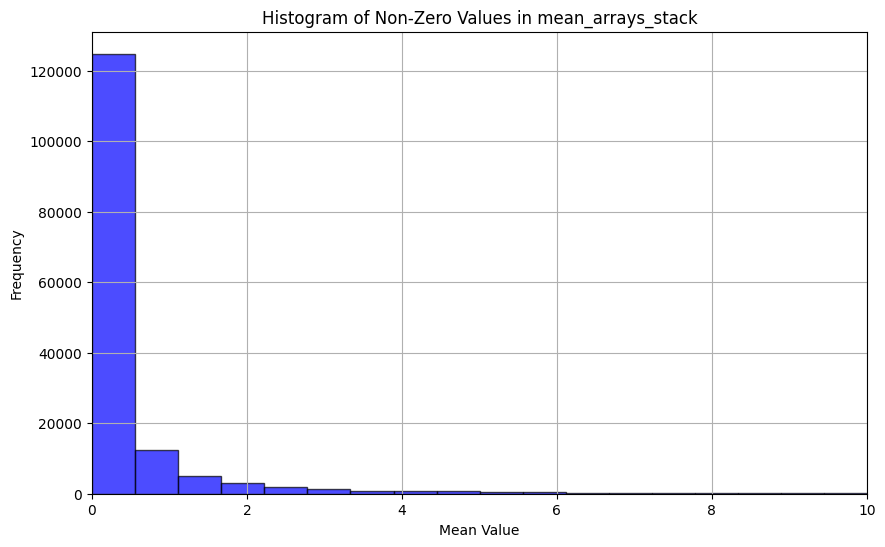

5


In [13]:
morphologies = ['3','4']
batches_3 =['3-mo-male-1',
          '3-mo-male-2',
          '3-mo-male-3-rev2',
          '3-mo-female-1-rev2',
          '3-mo-female-2',
          '3-mo-female-3']

young_4_soma, contact_thresh_set = calc_contacts(output_path, batches_3, morphologies,compartment='soma',contact_thresh = None)
young_4_branches = calc_contacts(output_path, batches_3, morphologies,compartment='branches',contact_thresh = contact_thresh_set)

In [14]:
# Define the batches (split by age) and most complex morphology
batches_24 =['24-mo-male-1',
          '24-mo-male-2',
          '24-mo-male-4-rev2',
          '24-mo-female-1',
          '24-mo-female-3',
          '24-mo-female-5']

#young_4_soma, young_4_branches = extract_coloc_tables(morphologies, batches_3,contact_thresh=10)
old_4_soma, old_4_branches = extract_coloc_tables(morphologies, batches_24,contact_thresh=contact_thresh_set)

In [15]:
os.makedirs('coloc_figs', exist_ok=True)
dataframes = [young_4_soma, young_4_branches, old_4_soma, old_4_branches]
sheet_names = ['Young_Soma', 'Young_Processes', 'Old_Soma', 'Old_Processes']

output_file = 'coloc_figs/gene_colocalization_networks.xlsx'
save_dataframes_to_excel(dataframes, sheet_names, output_file)

DataFrames saved to coloc_figs/gene_colocalization_networks.xlsx


In [16]:
for i in dataframes:
    print(len(i))

171
48
126
37


Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 1788.75it/s]


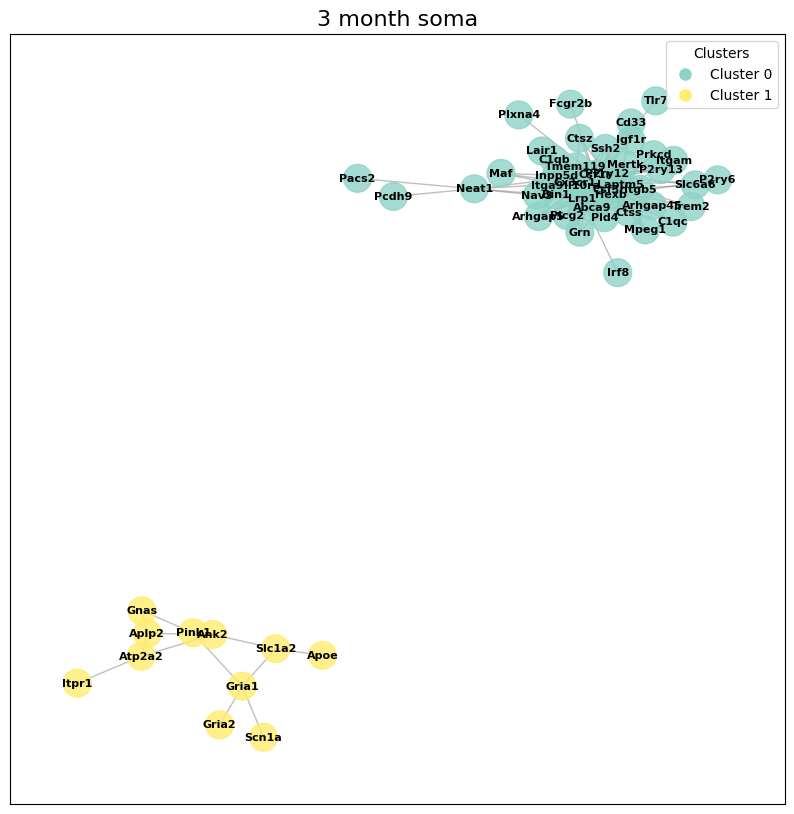

In [17]:
# Plot the graphs of the colocalization networks, clusters set to 3 by default, can manually tune
young_soma_gene_clusters = plot_contact_network_with_gmm(young_4_soma, '3 month soma',n_components=1, threshold=0.05,save_path='3_month_soma.pdf')

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 530.84it/s]


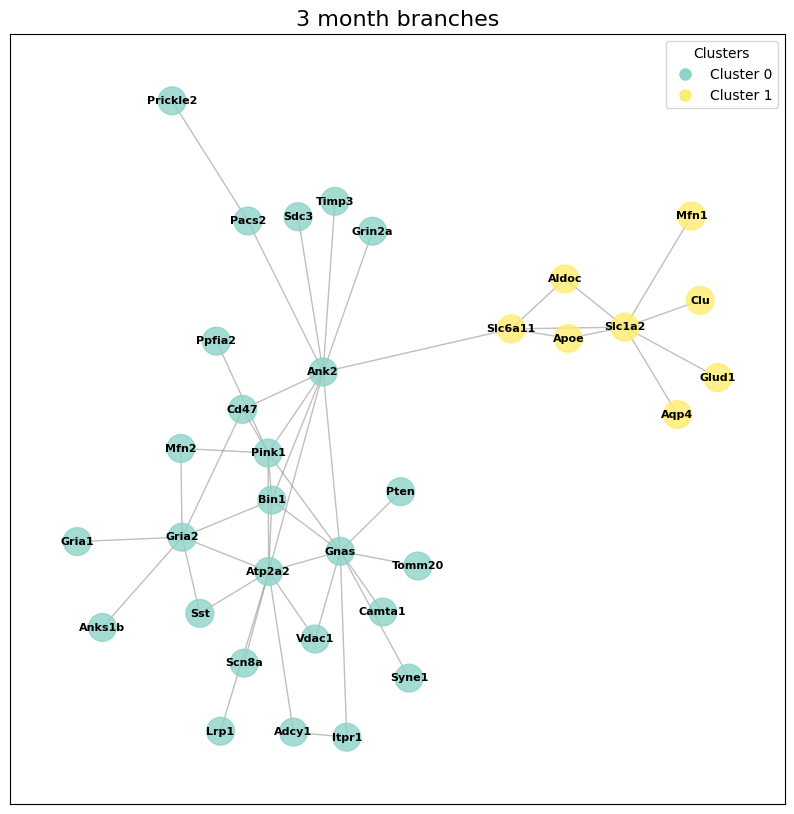

In [18]:
young_branches_gene_clusters = plot_contact_network_with_gmm(young_4_branches, '3 month branches',n_components=2, threshold=0.05,save_path='3_month_branches.pdf')

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 258.73it/s]


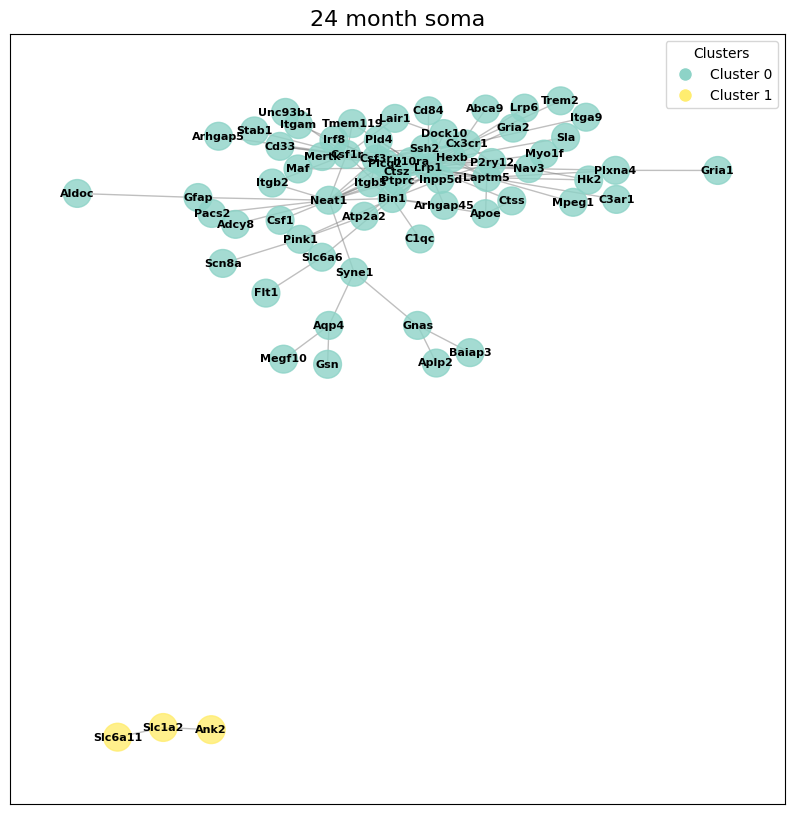

In [19]:
old_soma_gene_clusters = plot_contact_network_with_gmm(old_4_soma, '24 month soma', threshold=0.05,n_components=1,save_path='24_month_soma.pdf')

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 631.64it/s]


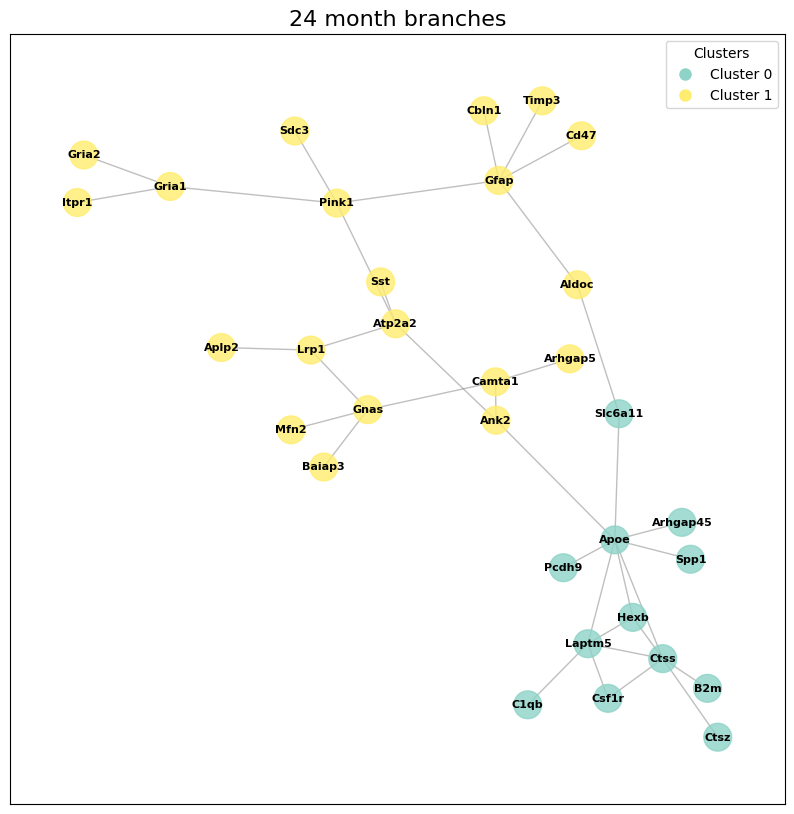

In [20]:
old_branches_gene_clusters = plot_contact_network_with_gmm(old_4_branches, '24 month branches', threshold=0.05,n_components=2,save_path='24_month_branches.pdf')

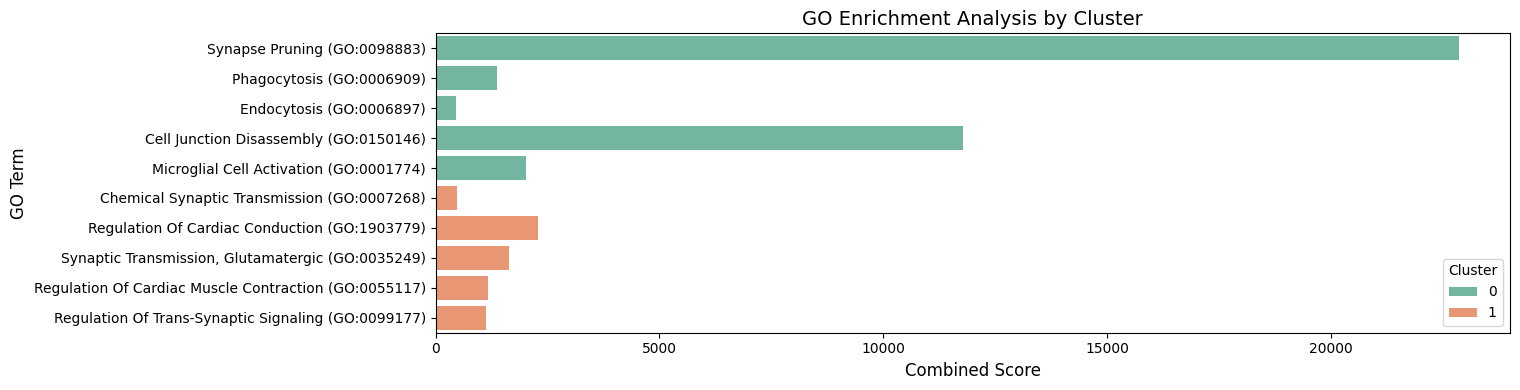

In [21]:
# 3 month soma gene ontology
results = perform_go_enrichment(young_soma_gene_clusters)
plot_go_enrichment(results, top_n=5,save_path='3_month_soma_GO.pdf',global_max_score=24000)

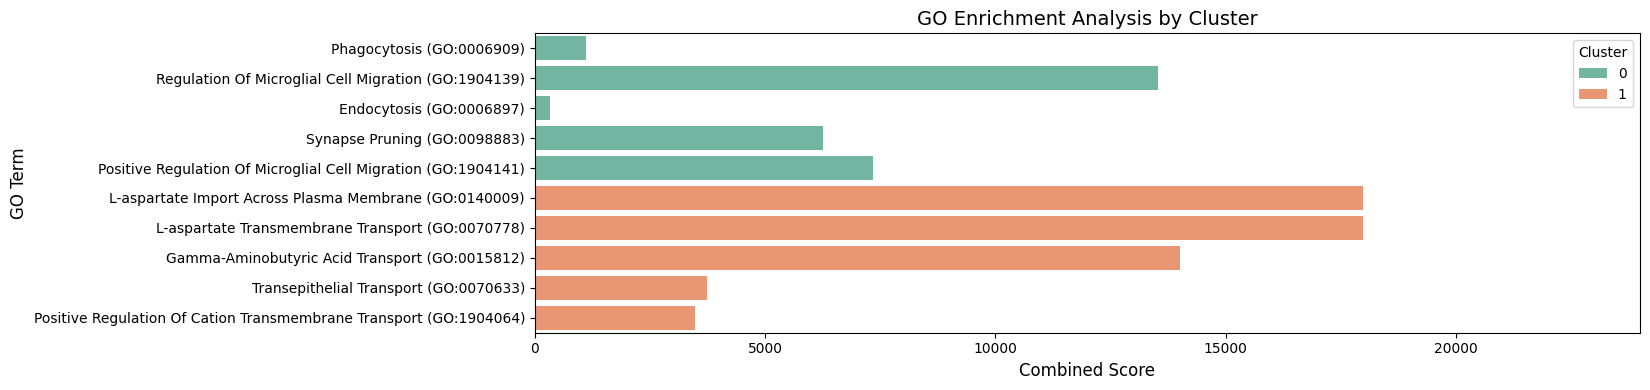

In [22]:
# 24 month soma gene ontology
results = perform_go_enrichment(old_soma_gene_clusters)
plot_go_enrichment(results, top_n=5,save_path='24_month_soma_GO.pdf',global_max_score=24000)

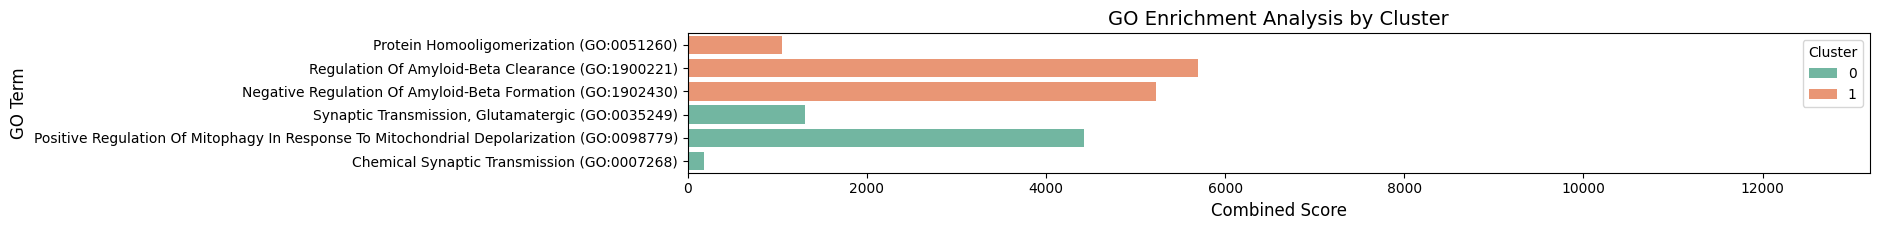

In [28]:
# 3 month branches gene ontology
results = perform_go_enrichment(young_branches_gene_clusters)
plot_go_enrichment(results, top_n=3,save_path='3_month_branches_GO.pdf',global_max_score=13200)

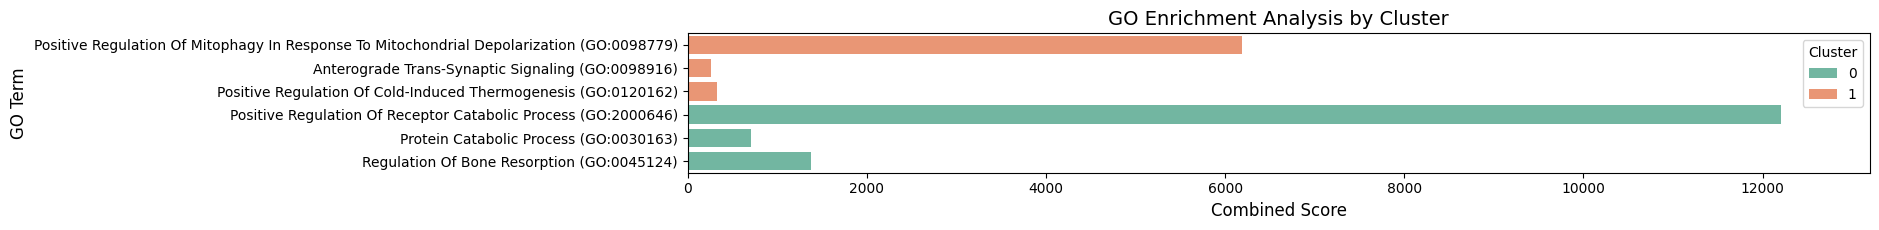

In [29]:
# 24 month branches gene ontology
results = perform_go_enrichment(old_branches_gene_clusters)
plot_go_enrichment(results, top_n=3,save_path='24_month_branches_GO.pdf',global_max_score=13200)